In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
data_cancer = pd.read_csv('cancer.csv')  # type: object
data_spam = pd.read_csv('spam.csv')
Y_cancer = np.array(data_cancer['label'])
Y_cancer = np.array([1 if Y_cancer[i] == 'M' else 0 for i in range(len(Y_cancer))])
X_cancer = np.array(data_cancer)[:, 1:]
Y_spam = np.array(data_spam['label'])
X_spam = np.array(data_spam)[:, :len(np.array(data_spam)[0]) - 1]
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split( 
          X_cancer, Y_cancer, test_size = 0.2, random_state = 100)
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split( 
          X_spam, Y_spam, test_size = 0.2, random_state = 100)

In [3]:
def gini(classes):
    unique_classes = np.unique(classes)
    probabilities = np.array([0.1] * len(unique_classes))
    i = 0
    for cl in unique_classes:
        n = len(classes[classes == cl])
        probabilities[i] = (n + 0.1 - 0.1) / len(classes)
        i += 1
    return np.sum(probabilities * (1 - probabilities))

In [4]:
class DecissionTree:
    def __init__(self, X, Y, maxdepth = 1, depth = 0):
        self.depth = depth
        if depth == 0:
            self.maxdepth = maxdepth
        self.probability = Counter(Y)[1] / len(Y)
        self.isLeaf = True
        if maxdepth == depth:
            self.isLeaf = True
            self.clas = Counter(Y).most_common(1)[0][0]
        else:
            ng = gini(Y)
            max = 0
            for i in range(len(X[0])):
                feats = X[:, i]
                for j in range(len(feats)):
                    left = Y[X[:, i] <= feats[j]]
                    right = Y[X[:, i] > feats[j]]
                    if len(left) and len(right):
                        lg = gini(left)
                        rg = gini(right)
                        ig = ng * len(Y) - lg * len(left) - rg * len(right)
                        if max < ig:
                            max = ig
                            self.sep = feats[j]
                            self.sep_num = i
            if max > 0:
                self.isLeaf = False
                self.left_child = DecissionTree(X[X[:, self.sep_num] <= self.sep], 
                                Y[X[:, self.sep_num] <= self.sep], maxdepth, depth + 1)
                self.right_child = DecissionTree(X[X[:, self.sep_num] > self.sep], 
                                Y[X[:, self.sep_num] > self.sep], maxdepth, depth + 1)
                
        
    def classify(self, x, depth = -1):
        if self.isLeaf or depth == 0:
            return self.probability
        if x[self.sep_num] <= self.sep:
            return self.left_child.classify(x, depth - 1)
        else:
            return self.right_child.classify(x, depth - 1)
        
    def classify_matrix(self, X, depth = -1):
        return np.array([self.classify(X[i], depth) for i in range(len(X))])

In [5]:
class RandomForest:
    def __init__(self, X, Y, maxdepth, n):
        self.maxdepth = maxdepth
        self.forest = []
        self.feats = []
        for i in range(n):
            print("Tree number: ", i)
            X1, X2, Y1, Y2 = train_test_split(X, Y, train_size=0.8)
            feats = np.random.permutation(len(X[0]))[:int(len(X[0]) * 0.8)]
            self.feats.append(feats)
            self.forest.append(DecissionTree(X1[:, feats], Y1, maxdepth))
        
    def classify_matrix(self, X, depth = -1):
        res = np.array([0] * len(X))
        for i in range(len(self.forest)):
            res = res + self.forest[i].classify_matrix(X[:, self.feats[i]], depth - 1)
        res /= len(self.forest)
        return res
    
    


In [322]:
fores = RandomForest(X_cancer_train, y_cancer_train, 3, 20)

Tree number:  0


Tree number:  1


Tree number:  2


Tree number:  3


Tree number:  4


Tree number:  5


Tree number:  6


Tree number:  7


Tree number:  8


Tree number:  9


Tree number:  10


Tree number:  11


Tree number:  12


Tree number:  13


Tree number:  14


Tree number:  15


Tree number:  16


Tree number:  17


Tree number:  18


Tree number:  19


AUC: 0.9918367346938776


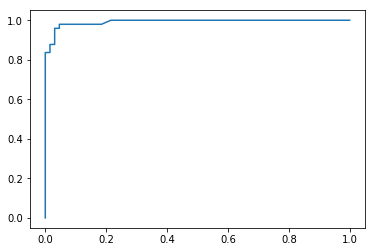

In [323]:
tps = []
fps = []
pr1 = fores.classify_matrix(X_cancer_test)
y_cancer_test[y_cancer_test == 0]
g1 = len(y_cancer_test[y_cancer_test == 1])
g0 = len(y_cancer_test[y_cancer_test == 0])
pairs = []
for i in range(len(pr1)):
    pairs.append((pr1[i], y_cancer_test[i]))
pairs.sort()
tp = g1
fp = g0
i = 0
fps.append(1)
tps.append(1)
while True:
    if i >= len(pairs):
            break
    pr = pairs[i][0]
    cl = pairs[i][1]
    prev = pr
    while True:
        if i >= len(pairs) or pr != prev:
            break
        pr = pairs[i][0]
        cl = pairs[i][1]
        if i >= len(pairs) or pr != prev:
            break
        tp -= int(cl == 1)
        fp -= int(cl == 0)
        i += 1
    tps.append(tp / g1)
    fps.append(fp / g0)
fig = plt.figure()
plt.plot(fps, tps)
fig.show()

tps.reverse()
fps.reverse()
prev_tp = tps[0]
prev_fp = fps[0]
area = 0
for tp, fp in zip(tps, fps):
    area += (fp - prev_fp) * (prev_tp + tp) / 2
    prev_tp = tp
    prev_fp = fp
print("AUC: " + str(area))

In [290]:
fores = RandomForest(X_spam_train, y_spam_train, 3, 20)

Tree number:  0


Tree number:  1


Tree number:  2


Tree number:  3


Tree number:  4


Tree number:  5


Tree number:  6


Tree number:  7


Tree number:  8


Tree number:  9


Tree number:  10


Tree number:  11


Tree number:  12


Tree number:  13


Tree number:  14


Tree number:  15


Tree number:  16


Tree number:  17


Tree number:  18


Tree number:  19


0.9479194139194141


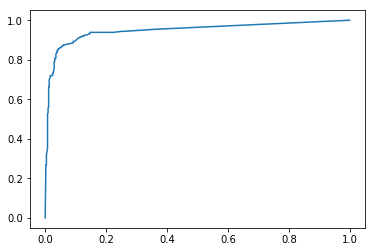

In [293]:
tps = []
fps = []
pr1 = fores.classify_matrix(X_spam_test)
y_spam_test[y_spam_test == 0]
g1 = len(y_spam_test[y_spam_test == 1])
g0 = len(y_spam_test[y_spam_test == 0])
pairs = []
for i in range(len(pr1)):
    pairs.append((pr1[i], y_spam_test[i]))
pairs.sort()
tp = g1
fp = g0
i = 0
fps.append(1)
tps.append(1)
while True:
    if i >= len(pairs):
            break
    pr = pairs[i][0]
    cl = pairs[i][1]
    prev = pr
    while True:
        if i >= len(pairs) or pr != prev:
            break
        pr = pairs[i][0]
        cl = pairs[i][1]
        if i >= len(pairs) or pr != prev:
            break
        tp -= int(cl == 1)
        fp -= int(cl == 0)
        i += 1
    tps.append(tp / g1)
    fps.append(fp / g0)
fig = plt.figure()
plt.plot(fps, tps)
fig.show()

tps.reverse()
fps.reverse()
prev_tp = tps[0]
prev_fp = fps[0]
area = 0
for tp, fp in zip(tps, fps):
    area += (fp - prev_fp) * (prev_tp + tp) / 2
    prev_tp = tp
    prev_fp = fp
print("AUC" + str(area))

In [7]:
forest_cancer = RandomForest(X_cancer_train, y_cancer_train, 10, 100)
forest_spam = RandomForest(X_spam_train, y_spam_train, 10, 100)

Tree number:  0


Tree number:  1


Tree number:  2


Tree number:  3


Tree number:  4


Tree number:  5


Tree number:  6


Tree number:  7


Tree number:  8


Tree number:  9


Tree number:  10


Tree number:  11


Tree number:  12


Tree number:  13


Tree number:  14


Tree number:  15


Tree number:  16


Tree number:  17


Tree number:  18


Tree number:  19


Tree number:  20


Tree number:  21


Tree number:  22


Tree number:  23


Tree number:  24


Tree number:  25


Tree number:  26


Tree number:  27


Tree number:  28


Tree number:  29


Tree number:  30


Tree number:  31


Tree number:  32


Tree number:  33


Tree number:  34


Tree number:  35


Tree number:  36


Tree number:  37


Tree number:  38


Tree number:  39


Tree number:  40


Tree number:  41


Tree number:  42


Tree number:  43


Tree number:  44


Tree number:  45


Tree number:  46


Tree number:  47


Tree number:  48


Tree number:  49


Tree number:  50


Tree number:  51


Tree number:  52


Tree number:  53


Tree number:  54


Tree number:  55


Tree number:  56


Tree number:  57


Tree number:  58


Tree number:  59


Tree number:  60


Tree number:  61


Tree number:  62


Tree number:  63


Tree number:  64


Tree number:  65


Tree number:  66


Tree number:  67


Tree number:  68


Tree number:  69


Tree number:  70


Tree number:  71


Tree number:  72


Tree number:  73


Tree number:  74


Tree number:  75


Tree number:  76


Tree number:  77


Tree number:  78


Tree number:  79


Tree number:  80


Tree number:  81


Tree number:  82


Tree number:  83


Tree number:  84


Tree number:  85


Tree number:  86


Tree number:  87


Tree number:  88


Tree number:  89


Tree number:  90


Tree number:  91


Tree number:  92


Tree number:  93


Tree number:  94


Tree number:  95


Tree number:  96


Tree number:  97


Tree number:  98


Tree number:  99


Tree number:  0


Tree number:  1


Tree number:  2


Tree number:  3


Tree number:  4


Tree number:  5


Tree number:  6


Tree number:  7


Tree number:  8


Tree number:  9


Tree number:  10


Tree number:  11


Tree number:  12


Tree number:  13


Tree number:  14


Tree number:  15


Tree number:  16


Tree number:  17


Tree number:  18


Tree number:  19


Tree number:  20


Tree number:  21


Tree number:  22


Tree number:  23


Tree number:  24


Tree number:  25


Tree number:  26


Tree number:  27


Tree number:  28


Tree number:  29


Tree number:  30


Tree number:  31


Tree number:  32


Tree number:  33


Tree number:  34


Tree number:  35


Tree number:  36


Tree number:  37


Tree number:  38


Tree number:  39


Tree number:  40


Tree number:  41


Tree number:  42


Tree number:  43


Tree number:  44


Tree number:  45


Tree number:  46


Tree number:  47


Tree number:  48


Tree number:  49


Tree number:  50


Tree number:  51


Tree number:  52


Tree number:  53


Tree number:  54


Tree number:  55


Tree number:  56


Tree number:  57


Tree number:  58


Tree number:  59


Tree number:  60


Tree number:  61


Tree number:  62


Tree number:  63


Tree number:  64


Tree number:  65


Tree number:  66


Tree number:  67


Tree number:  68


Tree number:  69


Tree number:  70


Tree number:  71


Tree number:  72


Tree number:  73


Tree number:  74


Tree number:  75


Tree number:  76


Tree number:  77


Tree number:  78


Tree number:  79


Tree number:  80


Tree number:  81


Tree number:  82


Tree number:  83


Tree number:  84


Tree number:  85


Tree number:  86


Tree number:  87


Tree number:  88


Tree number:  89


Tree number:  90


Tree number:  91


Tree number:  92


Tree number:  93


Tree number:  94


Tree number:  95


Tree number:  96


Tree number:  97


Tree number:  98


Tree number:  99


In [306]:
def classify_matrix(self, X, depth = -1, trees_num = None):
    if trees_num is None:
        trees_num = len(self.forest)
    res = np.array([0] * len(X))
    for i in range(trees_num):
        res = res + self.forest[i].classify_matrix(X[:, self.feats[i]], depth - 1)
    res /= len(self.forest)
    return res

for trees_num in [5, 10, 20, 30, 50, 100]:
    print("Число деревьев: " + str(trees_num))
    for depth in [2, 3, 5, 7, 10]:
        tps = []
        fps = []
        pr1 = classify_matrix(forest_cancer, X_cancer_test, depth, trees_num)
        y_cancer_test[y_cancer_test == 0]
        g1 = len(y_cancer_test[y_cancer_test == 1])
        g0 = len(y_cancer_test[y_cancer_test == 0])
        pairs = []
        for i in range(len(pr1)):
            pairs.append((pr1[i], y_cancer_test[i]))
        pairs.sort()
        tp = g1
        fp = g0
        i = 0
        fps.append(1)
        tps.append(1)
        while True:
            if i >= len(pairs):
                    break
            pr = pairs[i][0]
            cl = pairs[i][1]
            prev = pr
            while True:
                if i >= len(pairs) or pr != prev:
                    break
                pr = pairs[i][0]
                cl = pairs[i][1]
                if i >= len(pairs) or pr != prev:
                    break
                tp -= int(cl == 1)
                fp -= int(cl == 0)
                i += 1
            tps.append(tp / g1)
            fps.append(fp / g0)
        
        tps.reverse()
        fps.reverse()
        prev_tp = tps[0]
        prev_fp = fps[0]
        area = 0
        for tp, fp in zip(tps, fps):
            area += (fp - prev_fp) * (prev_tp + tp) / 2
            prev_tp = tp
            prev_fp = fp
        print("Depth: " + str(depth) + " AUC: " + str(area))

Число деревьев: 5
Depth: 2 AUC: 0.9822605965463108
Depth: 3 AUC: 0.9822605965463109
Depth: 5 AUC: 0.9849293563579278
Depth: 7 AUC: 0.9833594976452118
Depth: 10 AUC: 0.9843014128728416
Число деревьев: 10
Depth: 2 AUC: 0.9802197802197803
Depth: 3 AUC: 0.9827315541601255
Depth: 5 AUC: 0.9857142857142858
Depth: 7 AUC: 0.9839874411302983
Depth: 10 AUC: 0.986342229199372
Число деревьев: 20
Depth: 2 AUC: 0.9802197802197802
Depth: 3 AUC: 0.9872841444270016
Depth: 5 AUC: 0.9934065934065934
Depth: 7 AUC: 0.9941915227629513
Depth: 10 AUC: 0.9860282574568289
Число деревьев: 30
Depth: 2 AUC: 0.981789638932496
Depth: 3 AUC: 0.9872841444270016
Depth: 5 AUC: 0.9924646781789639
Depth: 7 AUC: 0.9945054945054945
Depth: 10 AUC: 0.9869701726844584
Число деревьев: 50
Depth: 2 AUC: 0.981789638932496
Depth: 3 AUC: 0.9854003139717427
Depth: 5 AUC: 0.9949764521193093
Depth: 7 AUC: 0.9954474097331241
Depth: 10 AUC: 0.9951334379905808
Число деревьев: 100
Depth: 2 AUC: 0.9814756671899528
Depth: 3 AUC: 0.9941915227

Оптимальный вариант для cancer: 50 деревьев глубины 7


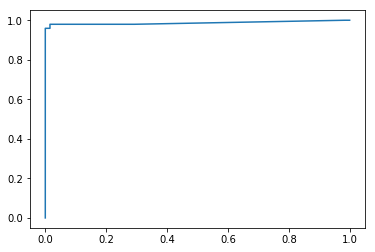

In [11]:
print("Оптимальный вариант для cancer: 50 деревьев глубины 7")
def classify_matrix(self, X, depth = -1, trees_num = None):
    if trees_num is None:
        trees_num = len(self.forest)
    res = np.array([0] * len(X))
    for i in range(trees_num):
        res = res + self.forest[i].classify_matrix(X[:, self.feats[i]], depth - 1)
    res /= len(self.forest)
    return res

while len(forest_cancer.forest) != 50:
    forest_cancer.forest.pop()
tps = []
fps = []
pr1 = classify_matrix(forest_cancer, X_cancer_test, 7)
y_cancer_test[y_cancer_test == 0]
g1 = len(y_cancer_test[y_cancer_test == 1])
g0 = len(y_cancer_test[y_cancer_test == 0])
pairs = []
for i in range(len(pr1)):
    pairs.append((pr1[i], y_cancer_test[i]))
pairs.sort()
tp = g1
fp = g0
i = 0
fps.append(1)
tps.append(1)
while True:
    if i >= len(pairs):
            break
    pr = pairs[i][0]
    cl = pairs[i][1]
    prev = pr
    while True:
        if i >= len(pairs) or pr != prev:
            break
        pr = pairs[i][0]
        cl = pairs[i][1]
        if i >= len(pairs) or pr != prev:
            break
        tp -= int(cl == 1)
        fp -= int(cl == 0)
        i += 1
    tps.append(tp / g1)
    fps.append(fp / g0)
fig = plt.figure()
plt.plot(fps, tps)
fig.show()

In [307]:
for trees_num in [5, 10, 20, 30, 50, 100]:
    print("Число деревьев: " + str(trees_num))
    for depth in [2, 3, 5, 7, 10]:
        tps = []
        fps = []
        pr1 = classify_matrix(forest_spam, X_spam_test, depth, trees_num)
        y_spam_test[y_spam_test == 0]
        g1 = len(y_spam_test[y_spam_test == 1])
        g0 = len(y_spam_test[y_spam_test == 0])
        pairs = []
        for i in range(len(pr1)):
            pairs.append((pr1[i], y_spam_test[i]))
        pairs.sort()
        tp = g1
        fp = g0
        i = 0
        fps.append(1)
        tps.append(1)
        while True:
            if i >= len(pairs):
                    break
            pr = pairs[i][0]
            cl = pairs[i][1]
            prev = pr
            while True:
                if i >= len(pairs) or pr != prev:
                    break
                pr = pairs[i][0]
                cl = pairs[i][1]
                if i >= len(pairs) or pr != prev:
                    break
                tp -= int(cl == 1)
                fp -= int(cl == 0)
                i += 1
            tps.append(tp / g1)
            fps.append(fp / g0)
        
        tps.reverse()
        fps.reverse()
        prev_tp = tps[0]
        prev_fp = fps[0]
        area = 0
        for tp, fp in zip(tps, fps):
            area += (fp - prev_fp) * (prev_tp + tp) / 2
            prev_tp = tp
            prev_fp = fp
        print("Depth: " + str(depth) + " AUC: " + str(area))

Число деревьев: 5
Depth: 2 AUC: 0.8511697191697192
Depth: 3 AUC: 0.9231916971916972
Depth: 5 AUC: 0.9646935286935288
Depth: 7 AUC: 0.9731501831501832
Depth: 10 AUC: 0.976395604395605
Число деревьев: 10
Depth: 2 AUC: 0.9091843711843711
Depth: 3 AUC: 0.9453382173382172
Depth: 5 AUC: 0.9636312576312578


Depth: 7 AUC: 0.9744542124542123
Depth: 10 AUC: 0.9769499389499381
Число деревьев: 20
Depth: 2 AUC: 0.9176898656898655
Depth: 3 AUC: 0.9470598290598291
Depth: 5 AUC: 0.963628815628816


Depth: 7 AUC: 0.9748840048840045
Depth: 10 AUC: 0.9793846153846147
Число деревьев: 30
Depth: 2 AUC: 0.9163174603174603
Depth: 3 AUC: 0.9475457875457876


Depth: 5 AUC: 0.9629597069597071
Depth: 7 AUC: 0.9756117216117218


Depth: 10 AUC: 0.97996336996337
Число деревьев: 50
Depth: 2 AUC: 0.9163223443223443
Depth: 3 AUC: 0.9475628815628816


Depth: 5 AUC: 0.9631184371184375


Depth: 7 AUC: 0.9752673992674004


Depth: 10 AUC: 0.9801098901098894
Число деревьев: 100
Depth: 2 AUC: 0.916092796092796


Depth: 3 AUC: 0.9461758241758242


Depth: 5 AUC: 0.9639926739926742


Depth: 7 AUC: 0.9747155067155091


Depth: 10 AUC: 0.9794920634920643


Оптимальный вариант для spam: 50 деревьев глубины 10


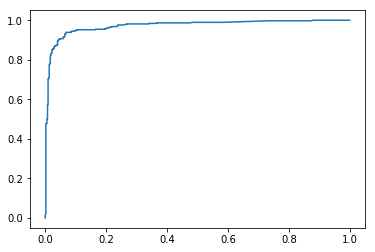

In [ ]:
print("Оптимальный вариант для spam: 50 деревьев глубины 10")
while len(forest_spam.forest) != 50:
    forest_spam.forest.pop()
tps = []
fps = []
pr1 = classify_matrix(forest_spam, X_spam_test, 10)
y_spam_test[y_spam_test == 0]
g1 = len(y_spam_test[y_spam_test == 1])
g0 = len(y_spam_test[y_spam_test == 0])
pairs = []
for i in range(len(pr1)):
    pairs.append((pr1[i], y_spam_test[i]))
pairs.sort()
tp = g1
fp = g0
i = 0
fps.append(1)
tps.append(1)
while True:
    if i >= len(pairs):
            break
    pr = pairs[i][0]
    cl = pairs[i][1]
    prev = pr
    while True:
        if i >= len(pairs) or pr != prev:
            break
        pr = pairs[i][0]
        cl = pairs[i][1]
        if i >= len(pairs) or pr != prev:
            break
        tp -= int(cl == 1)
        fp -= int(cl == 0)
        i += 1
    tps.append(tp / g1)
    fps.append(fp / g0)
fig = plt.figure()
plt.plot(fps, tps)
fig.show()